In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from statsmodels import api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Input, Flatten
from keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries, get_task2
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Configuration

In [2]:
SEQUENCE_SIZE = 178
BATCH_SIZE = 1024

# Data

In [3]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset['active_power'] = dataset['active_power'].rolling(window=12).mean()
dataset['active_power_mean'] = dataset['active_power'].rolling(window=12).mean()
dataset['active_power_std'] = dataset['active_power'].rolling(window=12).std()
dataset['active_power_diff1'] = dataset['active_power'].diff(-1)
dataset['active_power_diff2'] = dataset['active_power'].diff(-2)
dataset['active_power_diff3'] = dataset['active_power'].diff(-3)
dataset['active_power_diff4'] = dataset['active_power'].diff(-4)
dataset['active_power_diff5'] = dataset['active_power'].diff(-5)

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
dataset['active_power5'] = dataset['active_power']**5
dataset['active_power6'] = dataset['active_power']**6
dataset['active_power7'] = dataset['active_power']**7
dataset['active_power8'] = dataset['active_power']**8
dataset['active_power9'] = dataset['active_power']**9
dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.8)

train_y2 = get_task2(train_y)
test_y2 =  get_task2(test_y)

# train_y = pad_sequences(train_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# test_y = pad_sequences(test_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# train_y = pad_sequences(train_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)
# test_y = pad_sequences(test_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-29 17:35:30,968 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 14:02:00,0.593667,0.064,247.27,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 14:03:00,0.601167,0.064,247.45,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 14:04:00,0.608500,0.064,247.29,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 14:05:00,0.614333,0.066,247.92,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 14:06:00,0.612167,0.046,247.42,2.6,0.0,0.0,1.0,0,0,0


data_x: (43438, 46)
data_y: (43438, 1)

diff_x: (43438, 1)
diff_y: (43438, 1)

train_x: (33051, 178, 46)
train_y: (33051, 178, 1)

test_x: (8263, 178, 46)
test_y: (8263, 178, 1)


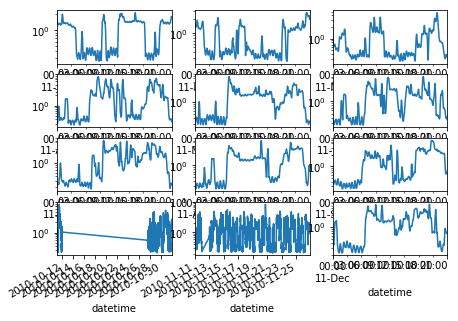

In [4]:
def show_active_power():
    fig, plots = subplots(4, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(5)
    fig.set_figwidth(7)

    for i, p in enumerate(plots):
        i += 1
        dataset['active_power'].loc[f'2010-{i:02}'].plot(logy=True, ax=p)
        
show_active_power()

파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


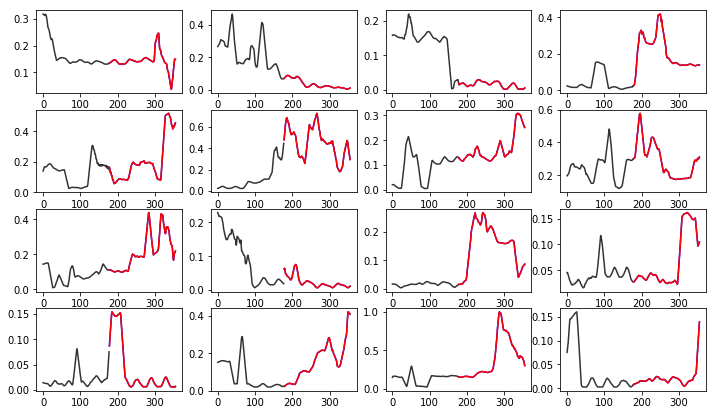

In [5]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n-SEQUENCE_SIZE)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')
        
print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

# Models

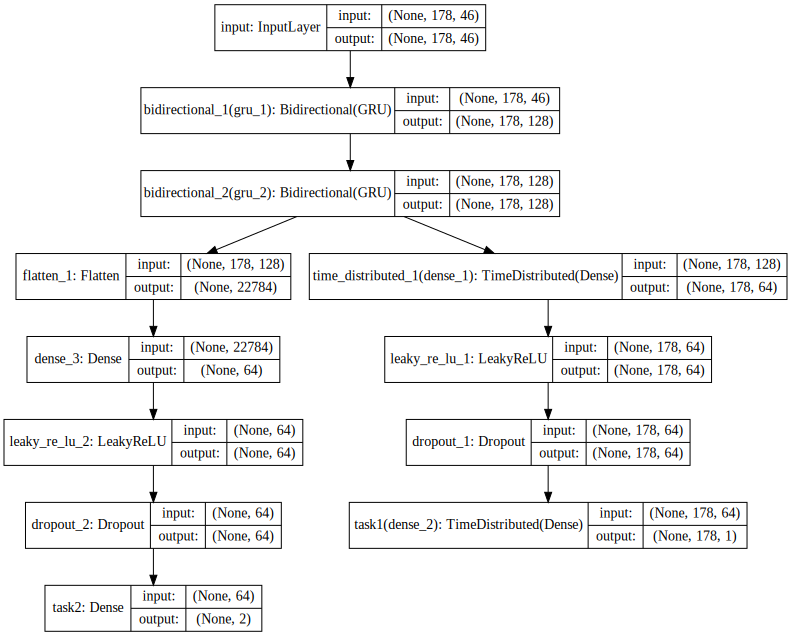

In [6]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1, l2, d1=64, d2=64, dout1=None, dout2=None, n_input=40):
    np.random.seed(0)
    input = Input(shape=(SEQUENCE_SIZE, n_input), name='input')
    rnn1 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.1))(input)
    rnn2 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.1))(rnn1)
    
    # Task 1
    h1 = TimeDistributed(Dense(d1))(rnn2)
    h1 = LeakyReLU()(h1)
    if dout1:
        h1 = Dropout(dout1)(h1)
    h1 = TimeDistributed(Dense(1), name='task1')(h1)
    
    # Task 2
    h2 = Flatten()(rnn2)
    h2 = Dense(d2)(h2)
    h2 = LeakyReLU()(h2)
    if dout2:
        h2 = Dropout(dout2)(h2)
    h2 = Dense(2, name='task2')(h2)
    
    model = Model(inputs=[input], outputs=[h1, h2])
    model.compile(optimizer=Adam(clipnorm=1.), 
                  loss={'task1': 'mse', 'task2': 'mse'},
                  loss_weights=[1., 0.3], 
                  metrics=[r2])
    return model

def create_model2(l1=64, l2=64, n_input=31):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(GRU(l1, return_sequences=True), input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Bidirectional(GRU(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(clipnorm=1.), metrics=[r2])
    return model

model = create_model(64, 64, d1=64, d2=64, dout1=0.2, dout2=0.2, n_input=46)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(64, 64, d1=64, d2=64, dout1=0.3, dout2=0.3, n_input=46)
history = History()
model.fit(train_x, [train_y, train_y2], epochs=200, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, [test_y, test_y2]), callbacks=[history])

In [ ]:
model = create_model(l1=64, l2=64, n_input=46)

history = History()
model.fit(train_x, train_y, epochs=200, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

# Evaluation

In [12]:
%time eval_results = model.evaluate(test_x, [test_y, test_y2], batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 1 s, sys: 204 ms, total: 1.2 s
Wall time: 1.2 s
loss: 0.009532968397576303
task1_loss: 0.007107914617659555
task2_loss: 0.008083513212601801
task1_r2: 0.33637292861476814
task2_r2: 0.637605770583824


[2486] r^2: -0.3337     
[3106] r^2: 0.3539      
[1309] r^2: 0.2769      
[4177] r^2: -0.4538     
[8123] r^2: -0.09829    
[2723] r^2: 0.5226      
[1624] r^2: -13.29      
[2622] r^2: 0.05963     
[800 ] r^2: -438.8      
[2729] r^2: 0.463       
[2079] r^2: -0.681      
[5672] r^2: -99.53      
[6442] r^2: -3.117      
[5076] r^2: -1.171      
[2357] r^2: -0.4116     
[6414] r^2: -2.443      


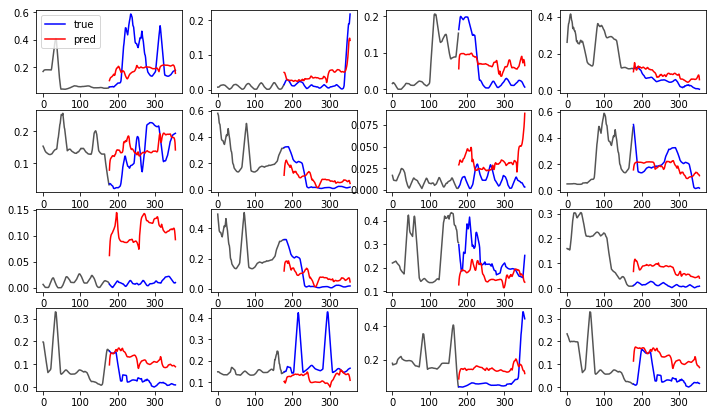

In [13]:
def vis_evaluate(model, test_x, test_y, batch=32):
    n = len(test_x)
    seq_n = test_x.shape[1]

    fig, plots = pylab.subplots(4, 4)
    plots = plots.reshape(-1)

    fig.set_figwidth(12)
    fig.set_figheight(7)

    for i, p in enumerate(plots):
        idx = np.random.randint(0, n)
        input_y = test_x[idx, :, 0]
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n * 2)

        true_y = test_y[idx]
        pred1, pred2 = model.predict(test_x[idx:idx + 1], batch_size=batch)

        score = r2_score(true_y.reshape(-1), pred1.reshape(-1))
        print(f'[{idx:<4}] r^2: {score:<12.4}')
        p.plot(x1, input_y, color='#555555')
        p.plot(x2, true_y, color='blue', label='true')
        p.plot(x2, pred1[0], color='red', label='pred')
        if i == 0:
            p.legend()


vis_evaluate(model, test_x, test_y, batch=BATCH_SIZE)